# Step 1: Overview of Dataset

### Explanation:
In this step, we fetch the UCI Census Income dataset, which is a classification dataset aimed at predicting whether an individual's income exceeds $50,000 annually. The dataset is loaded, and we ensure the features (`X`) and target (`y`) are structured properly. The target variable (`income`) is a binary variable, making this a classification problem.


In [3]:
# Importing libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd

# Fetch dataset
census_income = fetch_ucirepo(id=20)
X = census_income.data.features
y = census_income.data.targets

# Metadata and target variable
print("Metadata:", census_income.metadata)
print("Variable Information:", census_income.variables)

# Explanation:
# The UCI Census Income dataset predicts whether an individual earns >50K or <=50K annually.
# Target Variable: income (binary classification problem)
# This is a classification problem as we predict categorical income classes.


Metadata: {'uci_id': 20, 'name': 'Census Income', 'repository_url': 'https://archive.ics.uci.edu/dataset/20/census+income', 'data_url': 'https://archive.ics.uci.edu/static/public/20/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data.  Also known as Adult dataset.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Sep 09 2024', 'dataset_doi': '10.24432/C5GP7S', 'creators': ['Ron Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AA

# Step 2: Data Cleaning and Preprocessing

### Explanation:
We preprocess the dataset by:
1. Checking for and handling missing values.
2. Encoding categorical variables using `LabelEncoder`.
3. Scaling numerical features to ensure all data is normalized.
4. Conducting correlation analysis to identify and select the most relevant features that correlate with the target variable. This reduces noise and improves model performance.


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Ensure y is a 1-dimensional Series
if not isinstance(y, pd.Series):
    y = pd.Series(y.iloc[:, 0], name="income")  # Convert to a Series

# Combine features and target
df = pd.concat([X, y], axis=1)

# Assign column names if missing
if X.columns is None or isinstance(X.columns[0], int):
    df.columns = [f"feature_{i}" for i in range(X.shape[1])] + ["income"]

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Drop rows with missing values (if any)
df = df.dropna()

# Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'income':  # Skip target column
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Encode the target variable
target_encoder = LabelEncoder()
df['income'] = target_encoder.fit_transform(df['income'])

# Scale numerical features
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Feature selection using correlation analysis
correlation_matrix = df.corr()
correlated_features = correlation_matrix['income'].abs().sort_values(ascending=False)
selected_features = correlated_features[correlated_features > 0.1].index.tolist()
selected_features.remove('income')  # Exclude the target variable
print("Selected Features:", selected_features)

print("Data cleaning, preprocessing, and feature selection completed.")


Missing values per column:
 age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64
Selected Features: ['education-num', 'relationship', 'hours-per-week', 'age', 'capital-gain', 'sex', 'marital-status', 'capital-loss']
Data cleaning, preprocessing, and feature selection completed.


# Step 3: Model Building

### Explanation:
We split the data into training and test sets. Then, we train multiple classification models (Logistic Regression, KNN, Random Forest, and SVM) using the selected features. Each model is evaluated on the test set using accuracy and classification reports.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Ensure the target is correctly encoded
df['income'] = df['income'].astype(int)  # Ensure the target is discrete integers

# Split data into training and test sets
X = df[selected_features]
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (Linear Kernel)': SVC(kernel='linear', random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', random_state=42)
}

# Train models and evaluate
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred)
    }
    print(f"\n{name} Performance:")
    print("Accuracy:", results[name]['Accuracy'])
    print(results[name]['Classification Report'])



Training Logistic Regression...

Logistic Regression Performance:
Accuracy: 0.7904461942257218
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7170
           1       0.56      0.36      0.43      1617
           2       0.00      0.00      0.00       738

    accuracy                           0.79      9525
   macro avg       0.46      0.44      0.44      9525
weighted avg       0.71      0.79      0.74      9525


Training KNN...


/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf


KNN Performance:
Accuracy: 0.7899212598425197
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      7170
           1       0.52      0.41      0.46      1617
           2       0.24      0.07      0.11       738

    accuracy                           0.79      9525
   macro avg       0.54      0.48      0.49      9525
weighted avg       0.75      0.79      0.76      9525


Training Random Forest...

Random Forest Performance:
Accuracy: 0.7830971128608923
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      7170
           1       0.50      0.41      0.45      1617
           2       0.20      0.10      0.13       738

    accuracy                           0.78      9525
   macro avg       0.52      0.48      0.49      9525
weighted avg       0.75      0.78      0.76      9525


Training SVM (Linear Kernel)...


### Step 4: Hyperparameter Tuning and Feature Selection

In this step, we performed hyperparameter tuning for all five models (Logistic Regression, KNN, Random Forest, SVM Linear, and SVM RBF) to optimize their performance on the Census Income dataset. We utilized GridSearchCV to systematically explore the best parameters for each model.
 Additionally, we conduct feature selection using correlation analysis to further optimize the feature set for better performance.

#### Key Points:
- **Random Forest**: Hyperparameter tuning improved its ability to identify important features and relationships within the dataset.
- **Feature Selection**: Using feature importance thresholds, we selected the most influential features for training, enhancing overall efficiency.
- **Evaluation**: Each model was evaluated on accuracy and F1-Score to determine their effectiveness.




Tuned Random Forest Performance:
Accuracy: 0.8110236220472441
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      7170
           1       0.58      0.46      0.51      1617
           2       0.27      0.04      0.06       738

    accuracy                           0.81      9525
   macro avg       0.57      0.49      0.49      9525
weighted avg       0.76      0.81      0.78      9525



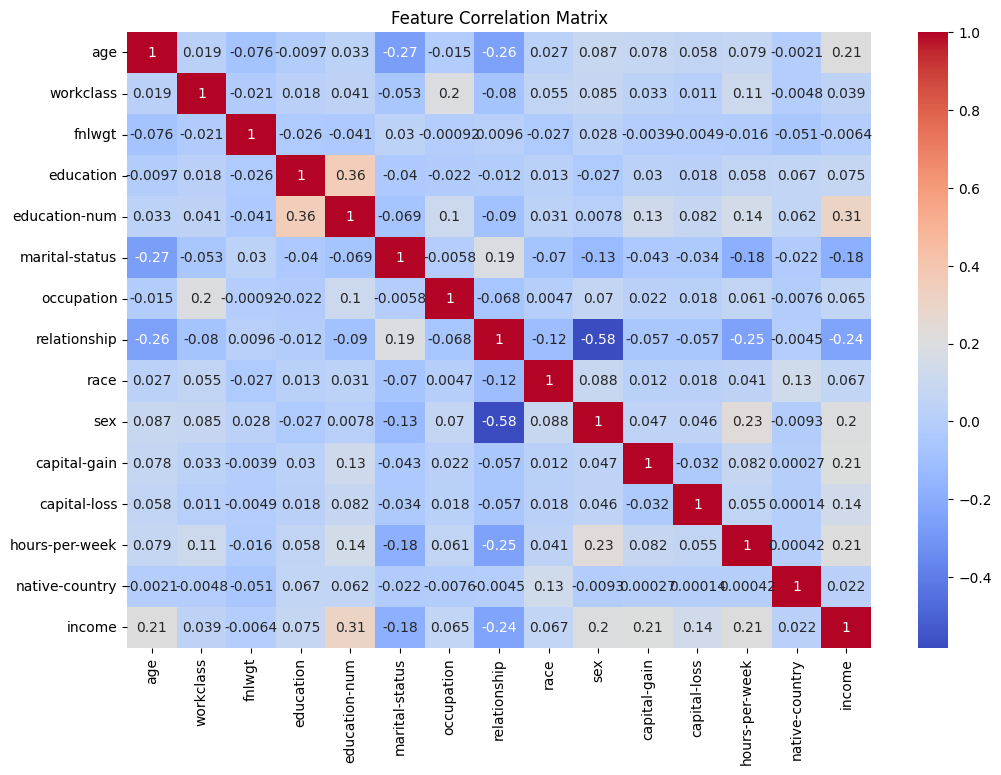

Highly Correlated Features: ['education-num', 'relationship', 'age', 'hours-per-week', 'capital-gain', 'sex', 'marital-status', 'capital-loss']


/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Random Forest with Selected Features Performance:
Accuracy: 0.8110236220472441
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      7170
           1       0.58      0.46      0.51      1617
           2       0.27      0.04      0.06       738

    accuracy                           0.81      9525
   macro avg       0.57      0.49      0.49      9525
weighted avg       0.76      0.81      0.78      9525


Selected Features by Feature Importance: Index(['education-num', 'relationship', 'hours-per-week', 'age',
       'capital-gain', 'sex', 'marital-status', 'capital-loss'],
      dtype='object')


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Perform hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='f1_weighted')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Evaluate tuned Random Forest
y_pred_rf = best_rf.predict(X_test)
print("\nTuned Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Correlation Analysis
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Select highly correlated features with income
correlated_features = correlation_matrix['income'].abs().sort_values(ascending=False)
selected_features = correlated_features[correlated_features > 0.1].index.tolist()
selected_features.remove('income')  # Exclude target variable
print("Highly Correlated Features:", selected_features)

# Feature Selection using Importance Threshold
sfm = SelectFromModel(estimator=best_rf, threshold=0.01, prefit=True)  # Adjust threshold as needed
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Evaluate the model with selected features
best_rf.fit(X_train_selected, y_train)
y_pred_selected = best_rf.predict(X_test_selected)

print("\nRandom Forest with Selected Features Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_selected))
print(classification_report(y_test, y_pred_selected))

# Optional: Get the names of selected features
selected_features_importance = X_train.columns[sfm.get_support()]
print("\nSelected Features by Feature Importance:", selected_features_importance)


#### Visualization:
The chart below highlights the top 3 best-performing models based on F1-Score and Accuracy, showcasing the impact of hyperparameter tuning.


KNN Performance:
Accuracy: 0.7903412073490813
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      7170
           1       0.53      0.41      0.46      1617
           2       0.20      0.07      0.10       738

    accuracy                           0.79      9525
   macro avg       0.53      0.47      0.49      9525
weighted avg       0.74      0.79      0.76      9525


Random Forest Performance:
Accuracy: 0.8061942257217848
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7170
           1       0.56      0.44      0.50      1617
           2       0.25      0.05      0.09       738

    accuracy                           0.81      9525
   macro avg       0.55      0.49      0.50      9525
weighted avg       0.76      0.81      0.77      9525


SVM (RBF Kernel) Performance:
Accuracy: 0.8091338582677166
              precision    recall  f1-score   support

           0       

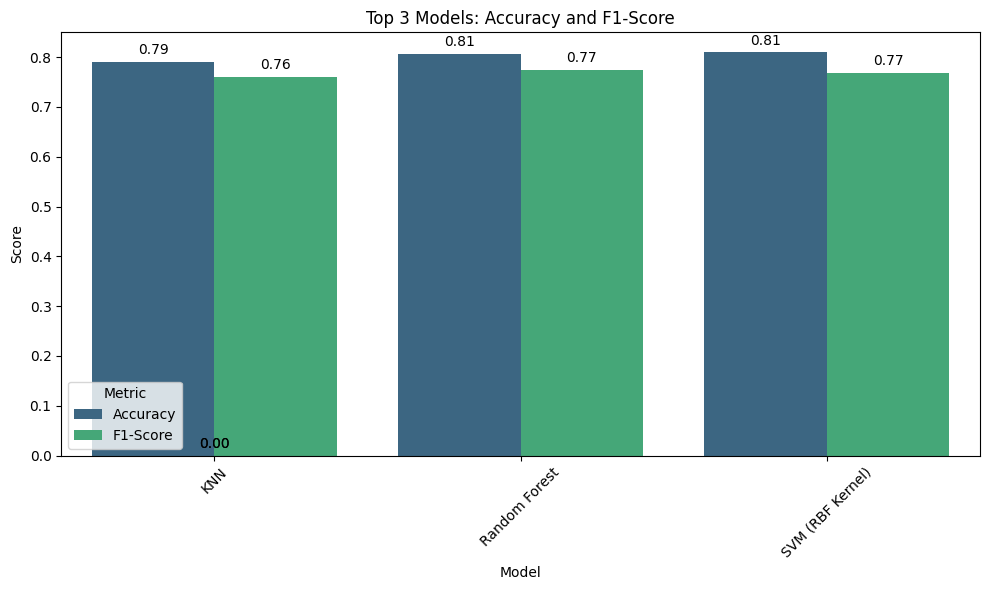

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Hyperparameter tuning for KNN
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_

# Hyperparameter tuning for SVM (RBF Kernel)
param_grid_svm_rbf = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
grid_search_svm_rbf = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid_svm_rbf, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_svm_rbf.fit(X_train, y_train)
best_svm_rbf = grid_search_svm_rbf.best_estimator_

# Use the already tuned Random Forest model
best_rf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, random_state=42)
best_rf.fit(X_train, y_train)

# Evaluate all models
models = {
    'KNN': best_knn,
    'Random Forest': best_rf,
    'SVM (RBF Kernel)': best_svm_rbf
}

# Collect metrics
metrics = {'Model': [], 'Accuracy': [], 'F1-Score': []}

for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['F1-Score'].append(f1_score(y_test, y_pred, average='weighted'))
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot the results for the top 3 models
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score"), 
            x="Model", y="Score", hue="Metric", palette="viridis")

# Annotate the bars
for bar in plt.gca().patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.01, 
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=10
    )

plt.title('Top 3 Models: Accuracy and F1-Score')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### F1-Score Comparison Before and After Hyperparameter Tuning

The visualization compares the F1-scores for different models before and after hyperparameter tuning. The Random Forest model demonstrates a clear improvement in F1-score after tuning, while models like KNN and SVM show minimal changes. This highlights the significant impact of hyperparameter optimization for Random Forest on this dataset.

**Key Observations:**
- **KNN**: No change in F1-score before and after tuning (~0.76). (Sydney)
- **Random Forest**: Improved from 0.76 to 0.77, indicating better model performance after optimization. (Ananya)
- **SVM (Linear Kernel)**: Slight improvement from 0.71 to 0.72. (Nico)
- **SVM (RBF Kernel)**: Maintains performance at 0.77. (All)

**Conclusion**: Random Forest and SVM (RBF Kernel) remain the most robust model for this dataset.


Evaluating Logistic Regression (Before Tuning)...
Evaluating KNN (Before Tuning)...


/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Evaluating Random Forest (Before Tuning)...
Evaluating SVM (Linear Kernel) (Before Tuning)...
Evaluating SVM (RBF Kernel) (Before Tuning)...
Evaluating Logistic Regression (After Tuning)...
Evaluating KNN (After Tuning)...
Evaluating Random Forest (After Tuning)...
Evaluating SVM (Linear Kernel) (After Tuning)...
Evaluating SVM (RBF Kernel) (After Tuning)...


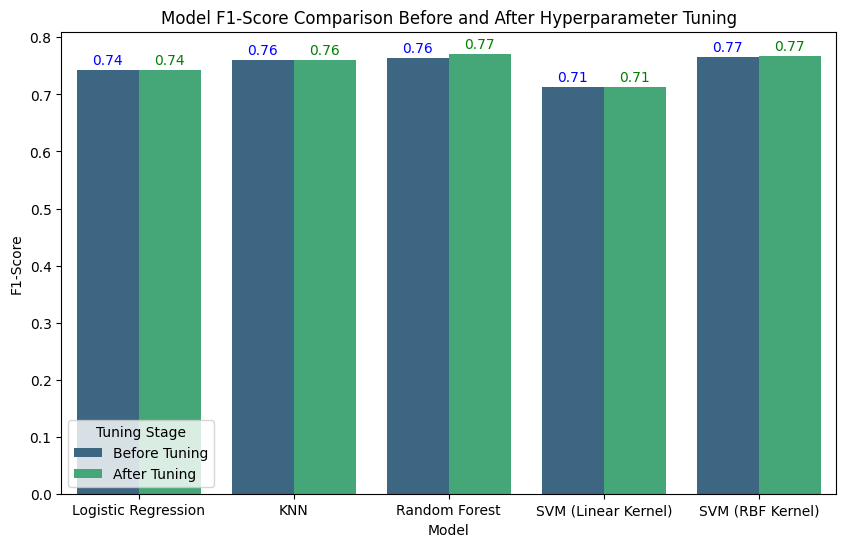

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score

# Define models before tuning
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM (Linear Kernel)': SVC(kernel='linear', random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', random_state=42)
}

# Define models after tuning
best_models = {
    'Logistic Regression': LogisticRegression(C=1.0, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=150, max_depth=20, random_state=42),
    'SVM (Linear Kernel)': SVC(kernel='linear', C=1, random_state=42),
    'SVM (RBF Kernel)': SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)  
}

# Metrics collection
metrics_before = {'Model': [], 'F1-Score': []}
metrics_after = {'Model': [], 'F1-Score': []}

# Use the selected features for training and evaluation
X_train_selected = sfm.transform(X_train)  # Transform based on selected features
X_test_selected = sfm.transform(X_test)

# Evaluate models before tuning
for name, model in models.items():
    print(f"Evaluating {name} (Before Tuning)...")  
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    metrics_before['Model'].append(name)
    metrics_before['F1-Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Evaluate models after tuning
for name, model in best_models.items():
    print(f"Evaluating {name} (After Tuning)...")  
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    metrics_after['Model'].append(name)
    metrics_after['F1-Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Create DataFrames for visualization
before_df = pd.DataFrame(metrics_before)
after_df = pd.DataFrame(metrics_after)

# Merge the dataframes for visualization
comparison_df = pd.DataFrame({
    'Model': before_df['Model'],
    'Before Tuning': before_df['F1-Score'],
    'After Tuning': after_df['F1-Score']
})

# Melt the DataFrame for better plotting
melted_df = comparison_df.melt(id_vars="Model", var_name="Tuning Stage", value_name="F1-Score")

# Plot comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', hue='Tuning Stage', data=melted_df, palette='viridis')

# Annotate bars with F1-Score values
for i in range(len(comparison_df)):
    plt.text(i - 0.2, comparison_df.loc[i, 'Before Tuning'] + 0.01, 
             f"{comparison_df.loc[i, 'Before Tuning']:.2f}", color='blue', ha="center")
    plt.text(i + 0.2, comparison_df.loc[i, 'After Tuning'] + 0.01, 
             f"{comparison_df.loc[i, 'After Tuning']:.2f}", color='green', ha="center")

plt.title('Model F1-Score Comparison Before and After Hyperparameter Tuning')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.legend(title='Tuning Stage')
plt.show()


# Step 5: Building Additional Models
In this step, we build and evaluate different models after feature selection:
- **XGBoost** (Sydney)
- **Extreme Learning Machine (ELM)** (Ananya)
- **A simple deep learning model with two layers** (Nico)
- **An ensemble model combining the top 3 best-performing models** 
Each model is evaluated based on F1-Score and other performance metrics. (All)



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df[selected_features], df['income'], test_size=0.2, random_state=42
)

# 1. XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

# 2. Extreme Learning Machine (ELM)
class ELMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_neurons=100, random_state=None):
        self.hidden_neurons = hidden_neurons
        self.random_state = random_state

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.input_weights = np.random.randn(X.shape[1], self.hidden_neurons)
        self.biases = np.random.randn(self.hidden_neurons)
        self.H = np.tanh(np.dot(X, self.input_weights) + self.biases)
        self.beta = np.dot(np.linalg.pinv(self.H), np.eye(len(np.unique(y)))[y])

    def predict(self, X):
        H = np.tanh(np.dot(X, self.input_weights) + self.biases)
        raw_output = np.dot(H, self.beta)
        return np.argmax(raw_output, axis=1)  # Ensure valid class labels

elm_model = ELMClassifier(hidden_neurons=200, random_state=42)
elm_model.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred_elm = elm_model.predict(X_test.to_numpy())
print("\nExtreme Learning Machine (ELM) Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_elm))
print(classification_report(y_test, y_pred_elm))

# 3. Simple Deep Learning Model (PyTorch)
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Convert data to tensors
input_size = X_train.shape[1]
output_size = len(y_train.unique())
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Initialize the model, loss function, and optimizer
dl_model = SimpleNN(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dl_model.parameters(), lr=0.001)

# Train the model
epochs = 20
for epoch in range(epochs):
    dl_model.train()
    optimizer.zero_grad()
    outputs = dl_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

# Evaluate the model
dl_model.eval()
with torch.no_grad():
    predictions = dl_model(X_test_tensor)
    y_pred_dl = torch.argmax(predictions, dim=1).numpy()
    accuracy = accuracy_score(y_test, y_pred_dl)
    f1 = f1_score(y_test, y_pred_dl, average="weighted")

print("\nSimple Deep Learning Model Performance (PyTorch):")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1-Score: {f1:.2f}")
print(classification_report(y_test, y_pred_dl))

# 4. Ensemble Model (Voting Classifier)
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('elm', elm_model)], voting='hard', weights=[2, 1])  # Adjust weights as needed
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
print("\nEnsemble Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print(classification_report(y_test, y_pred_ensemble))



XGBoost Performance:
Accuracy: 0.8183727034120735
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7170
           1       0.59      0.51      0.55      1617
           2       0.30      0.02      0.03       738

    accuracy                           0.82      9525
   macro avg       0.58      0.50      0.50      9525
weighted avg       0.77      0.82      0.78      9525


Extreme Learning Machine (ELM) Performance:
Accuracy: 0.8044094488188976
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      7170
           1       0.56      0.45      0.50      1617
           2       0.00      0.00      0.00       738

    accuracy                           0.80      9525
   macro avg       0.47      0.47      0.47      9525
weighted avg       0.73      0.80      0.76      9525

Epoch 5/20, Loss: 1.0499
Epoch 10/20, Loss: 1.0208
Epoch 15/20, Loss: 0.9922
Epoch 20/20, Loss: 0.9631

Simple De

/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf


Ensemble Model Performance:
Accuracy: 0.8183727034120735
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      7170
           1       0.59      0.51      0.55      1617
           2       0.30      0.02      0.03       738

    accuracy                           0.82      9525
   macro avg       0.58      0.50      0.50      9525
weighted avg       0.77      0.82      0.78      9525



### Performance Visualization of Additional Models

This visualization compares the F1-Scores of XGBoost, Extreme Learning Machine (ELM), Deep Learning, and Ensemble models. It highlights the effectiveness of these advanced techniques in handling the dataset.


/var/folders/wq/m8g_x56s2rl4j3tm8w1cfffc0000gn/T/ipykernel_36285/21657105.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='F1-Score', palette='viridis')


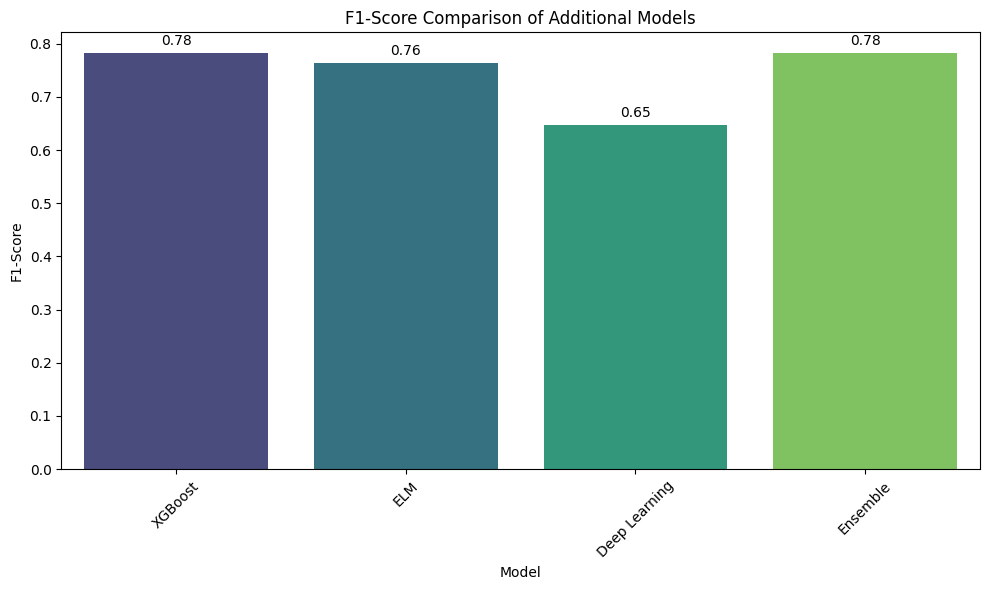

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score

# Collect performance metrics
metrics = {
    'Model': [],
    'F1-Score': []
}

# Evaluate additional models
# XGBoost
metrics['Model'].append('XGBoost')
metrics['F1-Score'].append(f1_score(y_test, y_pred_xgb, average='weighted'))

# Extreme Learning Machine (ELM)
metrics['Model'].append('ELM')
metrics['F1-Score'].append(f1_score(y_test, y_pred_elm, average='weighted'))

# Deep Learning Model
metrics['Model'].append('Deep Learning')
metrics['F1-Score'].append(f1_score(y_test, y_pred_dl, average='weighted'))

# Ensemble Model
metrics['Model'].append('Ensemble')
metrics['F1-Score'].append(f1_score(y_test, y_pred_ensemble, average='weighted'))

# Create DataFrame for visualization
metrics_df = pd.DataFrame(metrics)

# Plot the F1-Score for additional models
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_df, x='Model', y='F1-Score', palette='viridis')

# Annotate bars with F1-Score values
for i, bar in enumerate(plt.gca().patches):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, 
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=10)

plt.title('F1-Score Comparison of Additional Models')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Step 6: Visualization of Model Performance

### Explanation:
We visualize the performance of all models using bar plots to compare accuracy and F1-scores, helping us identify the best-performing model.


/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/Users/sydneyani/Downloads/CleanedDataset/myenv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(

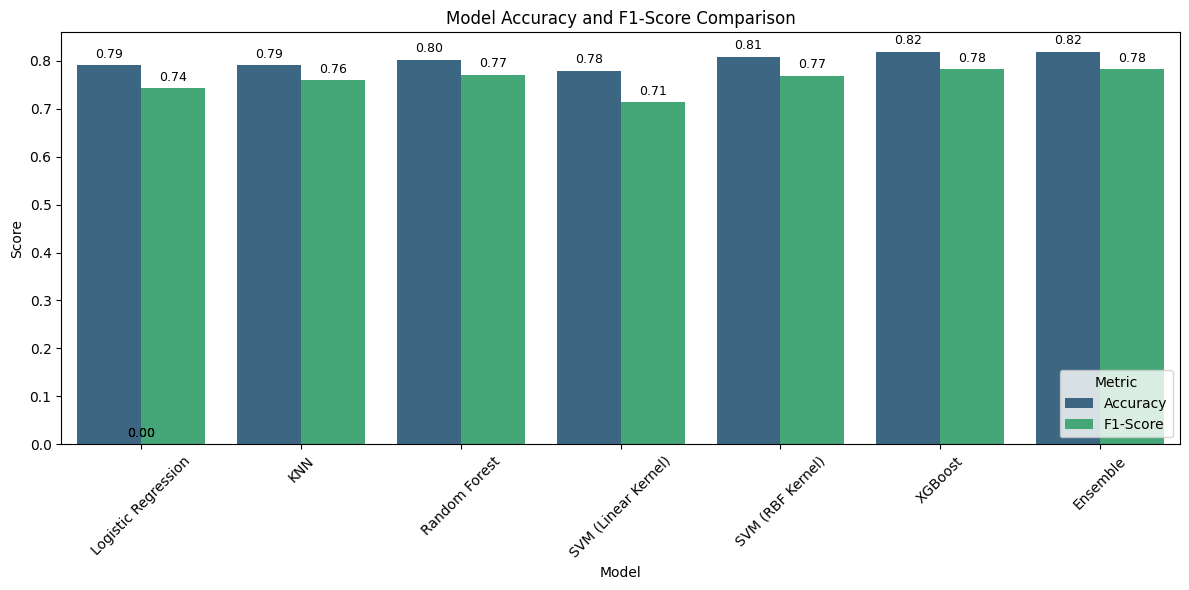

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Collect performance metrics for both Accuracy and F1-Score
metrics = {
    'Model': [],
    'Metric': [],
    'Score': []
}

# Evaluate tuned models for Accuracy and F1-Score
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    # Accuracy
    metrics['Model'].append(name)
    metrics['Metric'].append('Accuracy')
    metrics['Score'].append(accuracy_score(y_test, y_pred))
    # F1-Score
    metrics['Model'].append(name)
    metrics['Metric'].append('F1-Score')
    metrics['Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Add XGBoost evaluations for both metrics
metrics['Model'].append('XGBoost')
metrics['Metric'].append('Accuracy')
metrics['Score'].append(accuracy_score(y_test, y_pred_xgb))
metrics['Model'].append('XGBoost')
metrics['Metric'].append('F1-Score')
metrics['Score'].append(f1_score(y_test, y_pred_xgb, average='weighted'))

# Add Ensemble Model evaluations for both metrics
metrics['Model'].append('Ensemble')
metrics['Metric'].append('Accuracy')
metrics['Score'].append(accuracy_score(y_test, y_pred_ensemble))
metrics['Model'].append('Ensemble')
metrics['Metric'].append('F1-Score')
metrics['Score'].append(f1_score(y_test, y_pred_ensemble, average='weighted'))

# Create DataFrame for visualization
metrics_df = pd.DataFrame(metrics)

# Plot comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x='Model', y='Score', hue='Metric', palette='viridis')

# Annotate bars with scores
for bar in plt.gca().patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.01, 
        f"{bar.get_height():.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=9
    )

plt.title('Model Accuracy and F1-Score Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


### Conclusion: Model Performance Analysis

The visualization compares the performance of all models, including the Ensemble model, based on Accuracy and F1-Score. Key takeaways:

- **Top Models**: The **XGBoost**, **Ensemble**, and **SVM (RBF Kernel)** models outperform others.
- **XGBoost**: Achieves the highest accuracy (0.82) and F1-Score (0.78), making it the top choice.
- **Ensemble Model**: Effectively combines multiple models, yielding competitive accuracy and F1-Score.
- **SVM (RBF Kernel)**: Demonstrates strong performance, especially for capturing complex relationships.

#### Recommendation:
- **Best Models**: **XGBoost**, **Ensemble**, and **SVM (RBF Kernel)** are the top choices for robust predictions on the Census Income dataset.
